In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/ml_hw2")

<h3 style="text-align:center">
    In the name of God
</h3>
<p style="text-align:left">
    Machine Learning Course 1400, Dr. Sajedi
    <br>HW2
    <br>Alireza Kazemipour
    <br>610300171
</p>

In [16]:
!pip install nn-without-frameworks==0.0.14

In [17]:
%matplotlib inline

from nn_without_frameworks import numpy_nn as nn
from typing import List
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, log_loss
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import time

In [18]:
dataset = pd.read_csv('pd_speech_features.csv', skiprows=[0], encoding="utf-8")
print(dataset.keys())

Index(['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter',
       ...
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_30', 'tqwt_kurtosisValue_dec_31',
       'tqwt_kurtosisValue_dec_32', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=755)


In [19]:
dataset_vals = dataset.values
X = dataset_vals[..., :-1]
Y = dataset_vals[..., -1]
n_class = int(np.max(Y) + 1)
n_feat = X.shape[-1]
print(f"input's shape: {X.shape}")
print(f"labels's shape: {Y.shape}")

input's shape: (756, 754)
labels's shape: (756,)


In [20]:
pos_class = np.sum(Y == 1)
neg_class = np.sum(Y == 0)
print(f"number of class 1 instances: {pos_class}")
print(f"number of class 0 instances: {neg_class}")
print(f"imbalance ratio:{max(pos_class / neg_class, neg_class / pos_class):.2f}")

number of class 1 instances: 564
number of class 0 instances: 192
imbalance ratio:2.94


In [21]:
cv_num = 5
seed = 123

In [22]:
np.random.seed(seed)
shuffler = np.random.permutation(len(X))
X = X[shuffler]
Y = Y[shuffler]

In [23]:
test_idx = np.random.permutation(len(X))[:int(0.1 * len(X))]
x_test = X[test_idx]
y_test = Y[test_idx]

X = np.delete(X, test_idx, axis=0)
Y = np.delete(Y, test_idx, axis=0)
full_batch_size = X.shape[0]

In [24]:
scaler = StandardScaler() 
X = scaler.fit_transform(X)

In [25]:
def choose_fold(x, y, n):
    for i in range(n):
        x_val = x[i * full_batch_size // cv_num: (i + 1) * full_batch_size // cv_num]
        y_val = y[i * full_batch_size // cv_num: (i + 1) * full_batch_size // cv_num]

        x_train = np.delete(x, range(i * full_batch_size // cv_num, (i + 1) * full_batch_size // cv_num), axis=0)
        y_train = np.delete(y, range(i * full_batch_size // cv_num, (i + 1) * full_batch_size // cv_num), axis=0)

        yield x_train, y_train, x_val, y_val

In [26]:
class NNClassifier:
    def __init__(self,
                 hidden_units: List=[64],
                 epoch=500,
                 lr=0.001,
                 opt: nn.optims.Optimizer=nn.optims.SGD,
                 lam: float=0,
                 reg_type: str=None,
                 random_state=int(time.time())
                ):
        self.hidden_units = hidden_units
        self.epoch = epoch
        self.lr = lr
        self.opt = opt
        self.lam = lam
        self.reg_type = reg_type
        self.seed = random_state
        self.bce_loss = nn.losses.BinaryCrossEntropy() # FocalLoss(gamma=0.2)
        self.model = None
        self.best_weights = None
        self.loss_history = []
        
    def fit(self, x, y):
        self.loss_history = []
        nn.seed(self.seed)
        best_loss = np.inf
        self.best_weights = None
        self.model = None
        n_feat = int(x.shape[-1])
        # n_pos = np.sum(y == 1)
        # n_neg = np.sum(y == 0)

        if self.model is None:
            hidden_units = self.hidden_units
            
            hidden_layers = []
            for i in range(len(hidden_units)):
                hidden_layers.append(nn.layers.Dense(in_features=n_feat,
                                           out_features=hidden_units[i],
                                           activation=nn.acts.ReLU(),
                                           weight_initializer=nn.inits.HeNormal(nn.acts.ReLU()),
                                           bias_initializer=nn.inits.Constant(0.1),
                                           regularizer_type=self.reg_type,
                                           lam=self.lam)
                                    )
                hidden_layers.append(nn.layers.BatchNorm1d(hidden_units[i]))
                n_feat = hidden_units[i]

            if isinstance(hidden_layers[-1], nn.layers.BatchNorm1d):
                hidden_layers.pop(-1) 
            output_layer = nn.layers.Dense(in_features=self.hidden_units[-1],
                                      out_features=1,
                                      activation=nn.acts.Sigmoid(),
                                      weight_initializer=nn.inits.XavierUniform(),
                                      bias_initializer=nn.inits.Constant(0.01),
                                      regularizer_type=self.reg_type,
                                      lam=self.lam
                                      )
            
            
            self.model = nn.Sequential(*hidden_layers, output_layer)
        opt = self.opt(self.model.parameters, lr=self.lr)
            
        for step in range(self.epoch):
            y_pred = self.model(x)
            y_pred = y_pred.squeeze(-1)
            loss = self.bce_loss(y_pred, y)
            self.model.backward(loss)
            opt.apply()

            total_loss = loss.value
            total_loss += sum([0.5 * l.lam * np.sum(l.vars["W"] ** 2) for l in self.model._layers])

            if total_loss < best_loss:
              best_loss = total_loss
              self.best_weights = self.model.parameters


            if step == 0:
                self.loss_history.append(total_loss)
            else:
                self.loss_history.append(0.9 * self.loss_history[-1] + 0.1 * total_loss)
            
    def predict(self, x):
        assert not self.model is None
        self.model.set_weights(self.best_weights)
        pred = self.model(x)
        return np.where(pred > 0.5, 1, 0).squeeze(-1)
    
    def model_architecture(self):
        self.model.summary() 

In [89]:
class SingleLayerELMClassifier:
    def __init__(self,
                 units: int=64,
                 random_state=int(time.time())
                 ):
        """
        Reference:
        - [Introduction](https://towardsdatascience.com/introduction-to-extreme-learning-machines-c020020ff82b)
        - [code](https://github.com/burnpiro/elm-pure)
        """
        self.units = units
        self.seed = random_state
        self.beta = None
        self.H = None
        self.onehot_fn = OneHotEncoder(sparse=False)
        
    def fit(self, x, y):
        nn.seed(self.seed)
        self.beta = None
        self.H = None
        n_feat = int(x.shape[-1])
        # n_pos = np.sum(y == 1)
        # n_neg = np.sum(y == 0)

        if self.beta is None:
          self.H = nn.layers.Dense(in_features=n_feat,
                                  out_features=self.units,
                                  # activation=nn.acts.Tanh(),
                                  bias_initializer=nn.inits.RandomUniform()
                                  )
        H = self.H.forward(x)
        y = (y + 1).reshape(-1, 1)
        y = one_hot.fit_transform(y)
        
        self.beta = np.linalg.pinv(H).dot(y)
            
    def predict(self, x):
        assert not self.beta is None
        pred = self.H.forward(x).dot(self.beta)
        return np.argmax(pred, -1)

In [92]:
clfs = {
#     "Neural Net 256": {"base_clf": NNClassifier(hidden_units=[256],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
#         "Neural Net 128": {"base_clf": NNClassifier(hidden_units=[128],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
#         "Neural Net 64": {"base_clf": NNClassifier(hidden_units=[64],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
#         "Neural Net 64_32": {"base_clf": NNClassifier(hidden_units=[64, 32],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        }
# "Neural Net 256": {"base_clf": NNClassifier(hidden_units=[256],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
#         "Neural Net 128": {"base_clf": NNClassifier(hidden_units=[128],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
#         "Neural Net 64": {"base_clf": NNClassifier(hidden_units=[64],
#                                                 epoch=400,
#                                                 opt=nn.optims.Adam,
#                                                 lam=1e-3,
#                                                 reg_type="l2",
#                                                 random_state=seed
#                                                ),
#                        "param": "lr",
#                        "param_values": [1e-2, 1e-3, 1e-4, 1e-5]
#                        },
        "ELM": {"base_clf": SingleLayerELMClassifier(random_state=seed
                                               ),
                       "param": "units",
                       "param_values": 2 ** np.linspace(2, 9, num=8).astype(int)
                       }
        }

100%|██████████| 8/8 [00:02<00:00,  3.74it/s]


==> ELM <==
Training result:
	best param: units = 256
	best validation f1-score = 0.71


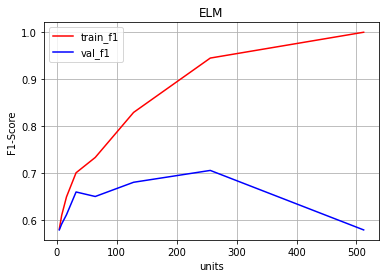


Test result: 


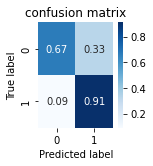

              precision    recall  f1-score   support

         0.0       0.71      0.67      0.69        18
         1.0       0.90      0.91      0.90        57

    accuracy                           0.85        75
   macro avg       0.80      0.79      0.80        75
weighted avg       0.85      0.85      0.85        75


🎁🎁🎁best_model is: ELM with test f1-score = 0.80%.


In [93]:
best_test_f1 = -np.inf
best_model = {}

for clf_name, config in clfs.items():
    history = {"train_f1": [], "val_f1": []}
    best_val_f1 = 0
    best_param = None

    for p in tqdm(config["param_values"]):
        avg_val_f1 = 0
        avg_train_f1 = 0

        for x_train, y_train, x_val, y_val in choose_fold(X, Y, cv_num):
            clf = config["base_clf"]
            setattr(clf, "random_state", seed)
            setattr(clf, config["param"], p)
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_train)
            avg_train_f1 += f1_score(y_train, y_pred, average='macro')
            y_pred = clf.predict(x_val)
            avg_val_f1 += f1_score(y_val, y_pred, average='macro')

        history["train_f1"].append(avg_train_f1 / cv_num)
        history["val_f1"].append(avg_val_f1 / cv_num)

        if history["val_f1"][-1] > best_val_f1:
            best_val_f1 = history["val_f1"][-1]
            best_param = p
            if "Neural Net" in clf_name:
                best_loss_hist = clf.loss_history

    print(f"==> {clf_name} <==")
    print("Training result:")
    print("\tbest param: {} = {}\n\tbest validation f1-score = {:.2f}".format(config["param"],
                                                                               best_param,
                                                                               best_val_f1))        
    plt.plot(config["param_values"], history["train_f1"], c="r")
    plt.plot(config["param_values"], history["val_f1"], c="b")
    plt.legend(history.keys())
    plt.grid()
    plt.title(clf_name)
    plt.ylabel("F1-Score")
    plt.xlabel(config["param"])
    if any(name in clf_name for name in ["SVM", "XGBoost", "Neural Net"]):
        plt.xscale("log")
    plt.show()
    
    if "Neural Net" in clf_name:
        clf.model_architecture()
        plt.plot()
        plt.plot(range(clf.epoch), best_loss_hist)
        plt.grid()
        plt.title("Training Loss")
        plt.ylabel("Loss")
        plt.xlabel("epoch")
        plt.show()
        
    print("\nTest result: ")
    setattr(clf, config["param"], best_param)
    clf.fit(X, Y)
    x_test_stand = scaler.transform(x_test)
    y_pred = clf.predict(x_test_stand)
    test_f1 = f1_score(y_test, y_pred, average='macro')
    if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        best_model["name"] = clf_name
        best_model["clf"] = clf
    con_mat = confusion_matrix(y_test, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index=[i for i in range(n_class)], columns=[i for i in range(n_class)])
    figure = plt.figure(figsize=(n_class, n_class))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    report = classification_report(y_test, y_pred)
    print(report)

    if clf_name == "Decision Tree":
        setattr(clfs["Random Forest"]["base_clf"], "max_depth", best_param)
        setattr(clfs["XGBoost"]["base_clf"], "max_depth", best_param)

    if clf_name == "Random Forest":
        setattr(clfs["XGBoost"]["base_clf"], "n_estimators", best_param)
        
print(f"\n🎁🎁🎁best_model is: {best_model['name']} with test f1-score = {best_test_f1:.2f}%.")